# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin

from decision_tree import DecisionTree, find_best_split

In [2]:
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [3]:
datasets = [
    ('Circles', make_circles(noise=0.2, factor=0.5, random_state=42)),
    ('Moons', make_moons(noise=0.2, random_state=42)),
    ('Classification', make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, ))
]

In [4]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

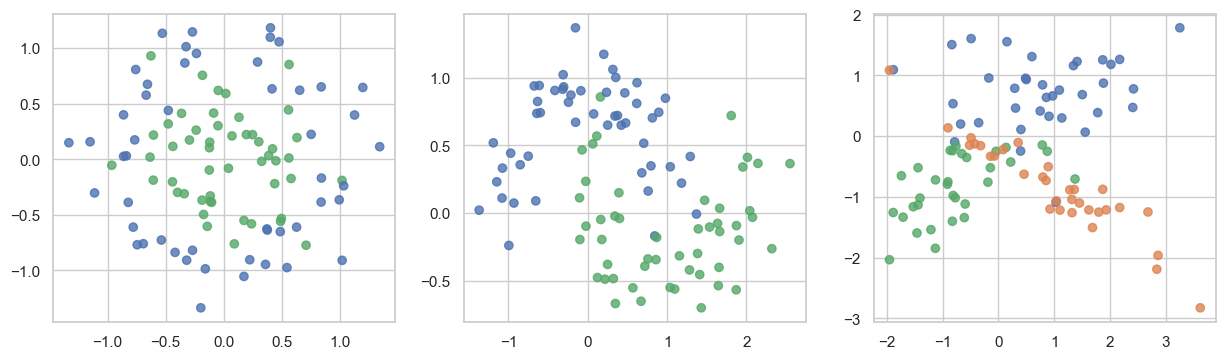

In [5]:
plt.figure(figsize=(15, 4))
for i, (_, (x, y)) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [6]:
def plot_surface(clf, X, y, ax=None, title=None):
    if ax is None:
        ax = plt.gca()

    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)
    
    if title:
        ax.set_title(title)

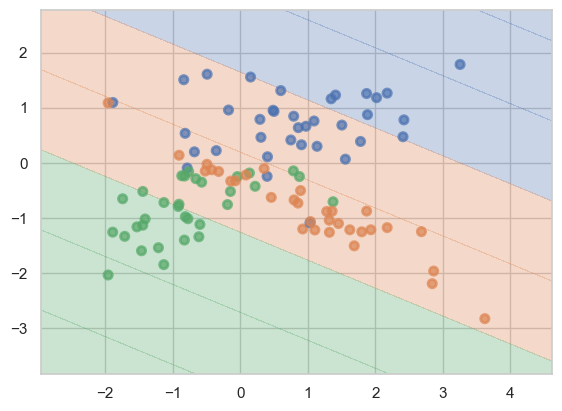

In [7]:
# Пример:
X, y = datasets[2][1]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

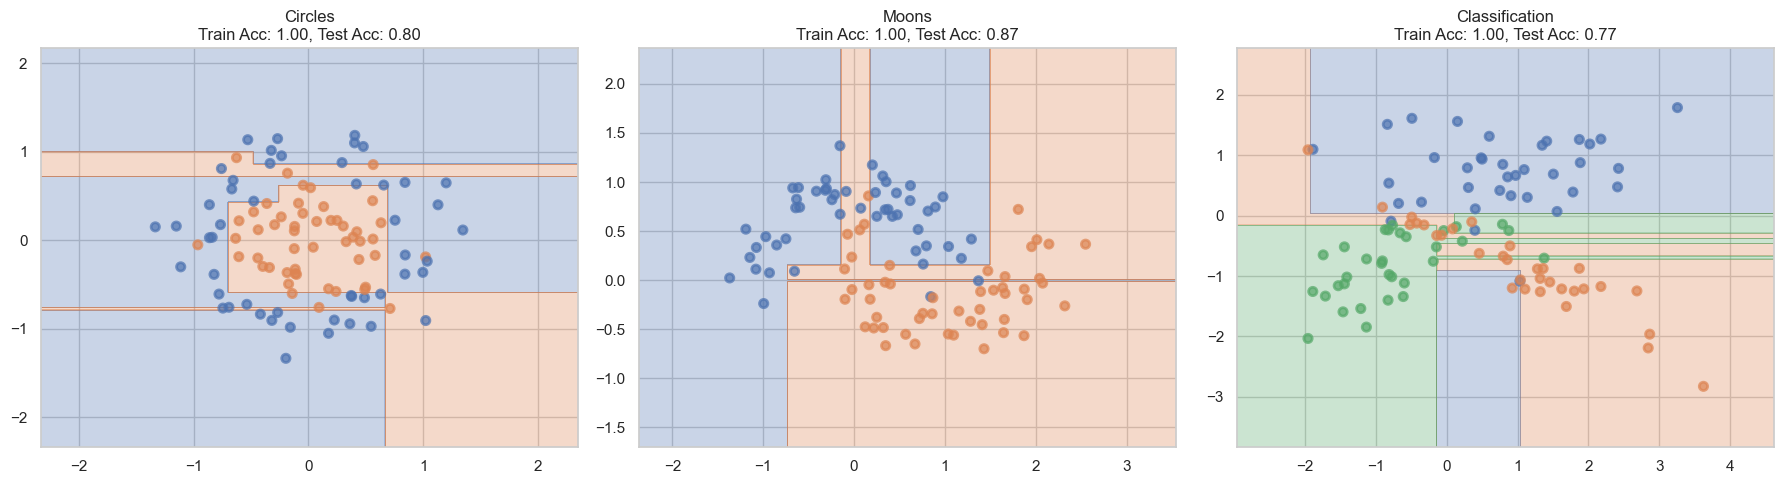

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, (X, y)) in zip(axs, datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = DecisionTreeClassifier().fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    plot_surface(clf, X, y, ax=ax, title=f"{name}\nTrain Acc: {train_acc:.2f}, Test Acc: {test_acc:.2f}")

plt.tight_layout()
plt.show()

__Ответ:__

Деревья на графиках сильно переобучились. На всех трёх графиках видно, что деревья построили крайне изломанные границы — они практически идеально повторяют обучающие точки, но не захватывают общее распределение классов.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?


Dataset: Circles


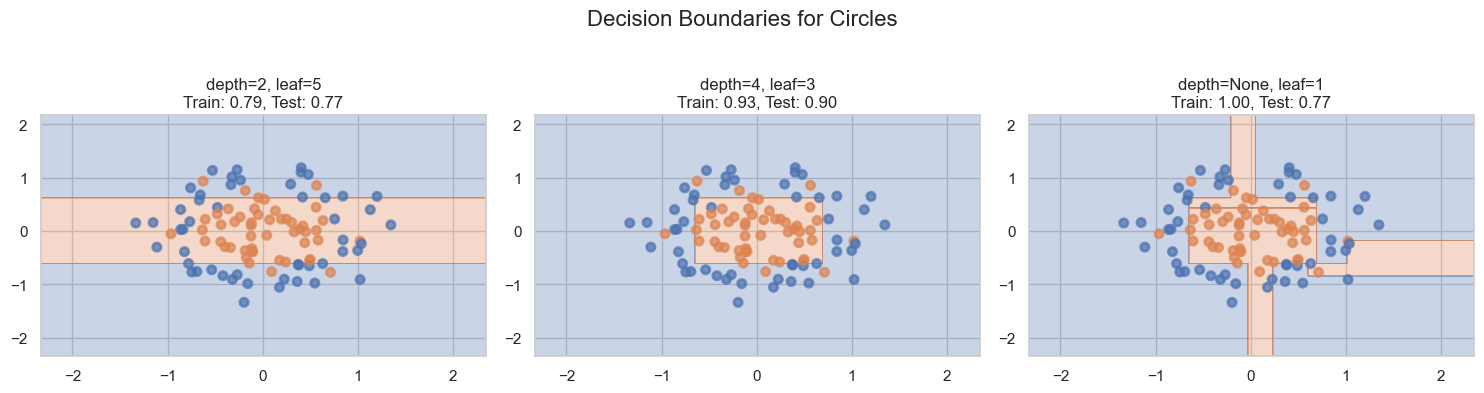


Dataset: Moons


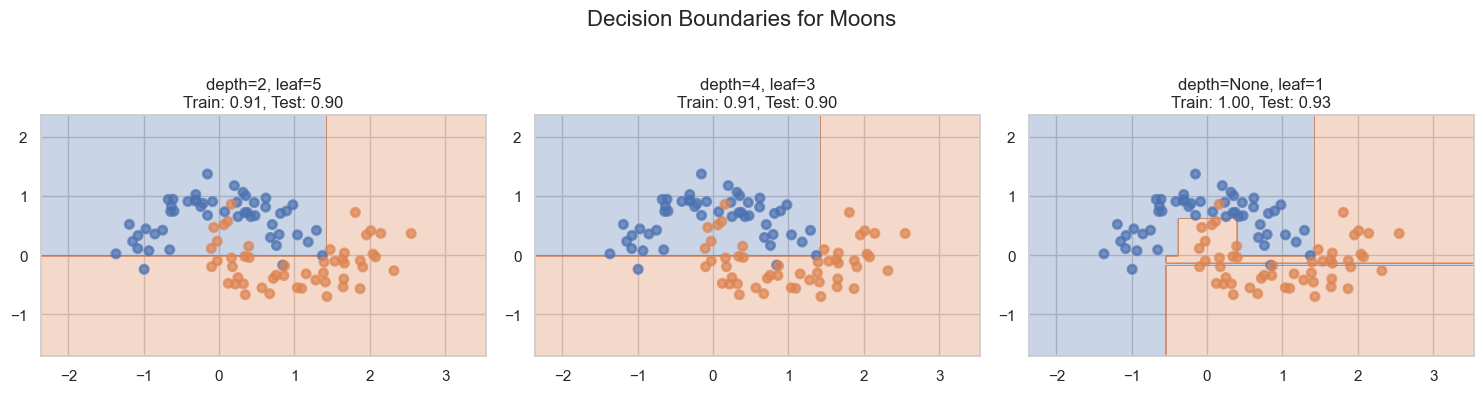


Dataset: Classification


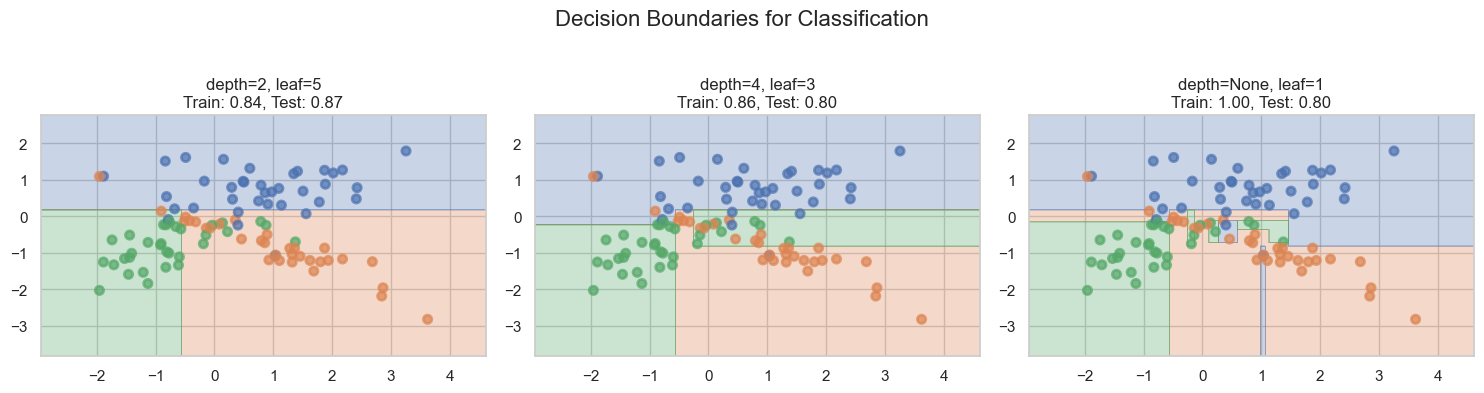

In [9]:
param_grid = [
    {"max_depth": 2, "min_samples_leaf": 5},
    {"max_depth": 4, "min_samples_leaf": 3},
    {"max_depth": None, "min_samples_leaf": 1},
]

for name, (X, y) in datasets:
    print(f"\nDataset: {name}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    fig, axs = plt.subplots(1, len(param_grid), figsize=(15, 4))
    fig.suptitle(f"Decision Boundaries for {name}", fontsize=16)

    for ax, params in zip(axs, param_grid):
        clf = DecisionTreeClassifier(**params, random_state=0)
        clf.fit(X_train, y_train)

        train_acc = accuracy_score(y_train, clf.predict(X_train))
        test_acc = accuracy_score(y_test, clf.predict(X_test))

        plot_surface(clf, np.vstack([X_train, X_test]), np.hstack([y_train, y_test]), ax=ax)

        ax.set_title(f"depth={params['max_depth']}, leaf={params['min_samples_leaf']}\n"
                     f"Train: {train_acc:.2f}, Test: {test_acc:.2f}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

__Ответ:__

По графикам видно, что с увеличением глубины дерева и уменьшением минимального количества объектов в листьях разделяющая поверхность становится более сложной и изломанной. Это говорит о росте гибкости модели, но одновременно и о повышении риска переобучения.

Для датасета "Circles" при увеличении сложности модели тестовая точность сначала растёт, достигает пика (0.90), а затем снова падает (до 0.77), что подтверждает переобучение. Для "Moons" тестовая точность почти не ухудшается даже при переобучении, поскольку это позволяет структура классов. Для "Classification" с тремя классами наблюдается умеренное переобучение: на последней модели обучающая точность 1.00, но тестовая остаётся на уровне 0.80, как и у менее сложной модели.

Таким образом, изменение разделяющей поверхности и обобщающей способности при усложнении модели зависит от формы распределения данных. На простых и хорошо разделимых датасетах переобучение проявляется слабее, а на более сложных структурах становится ярко выраженным.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

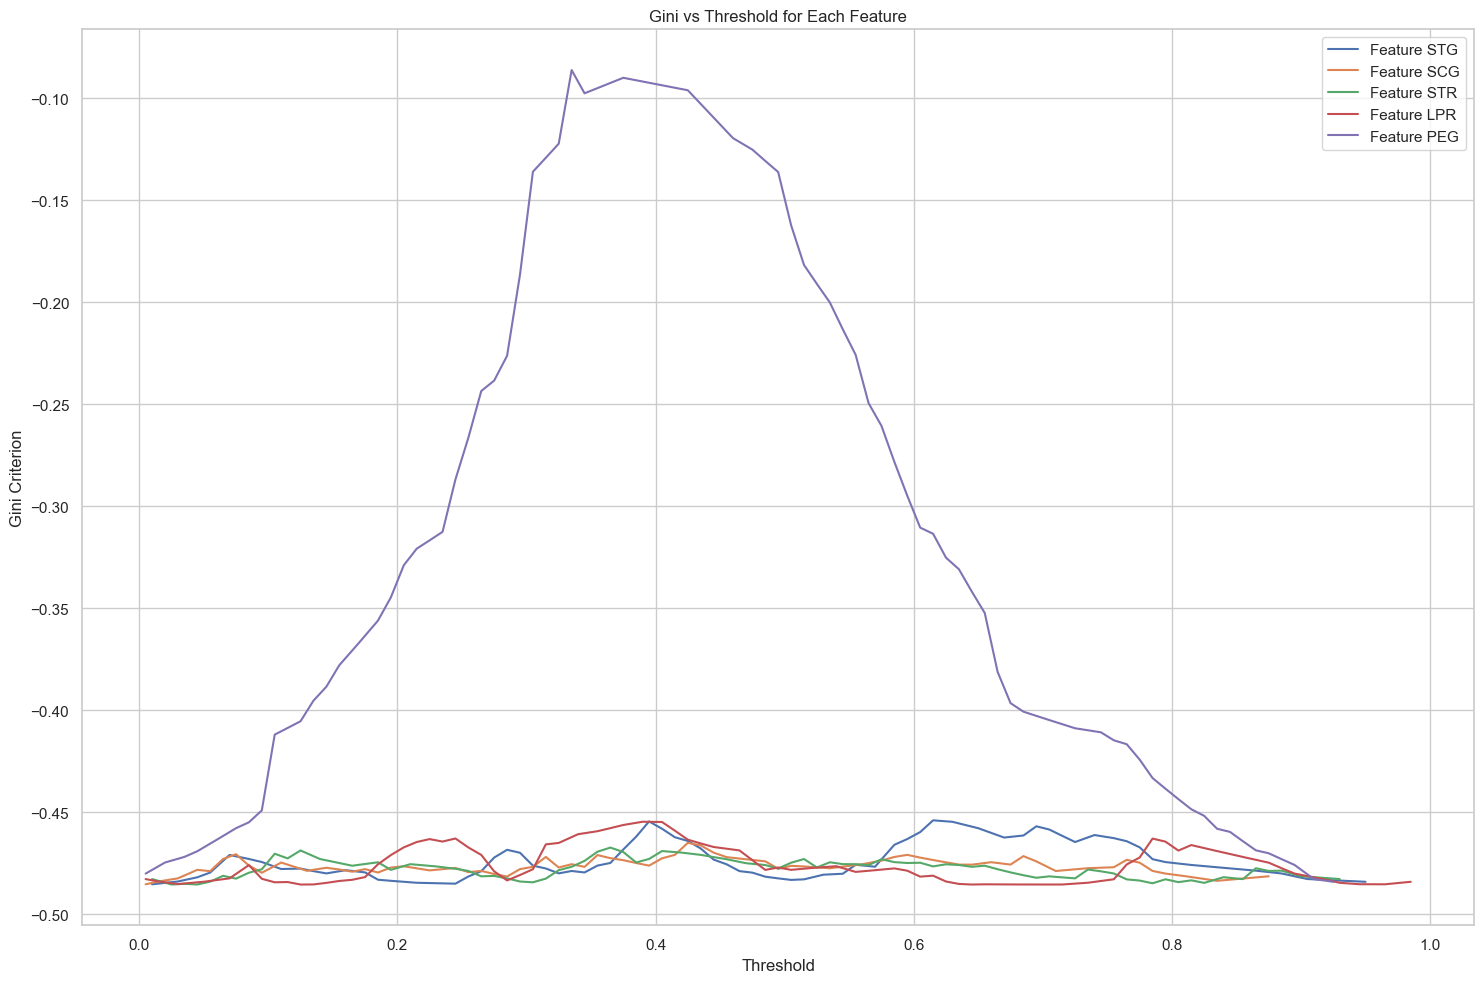

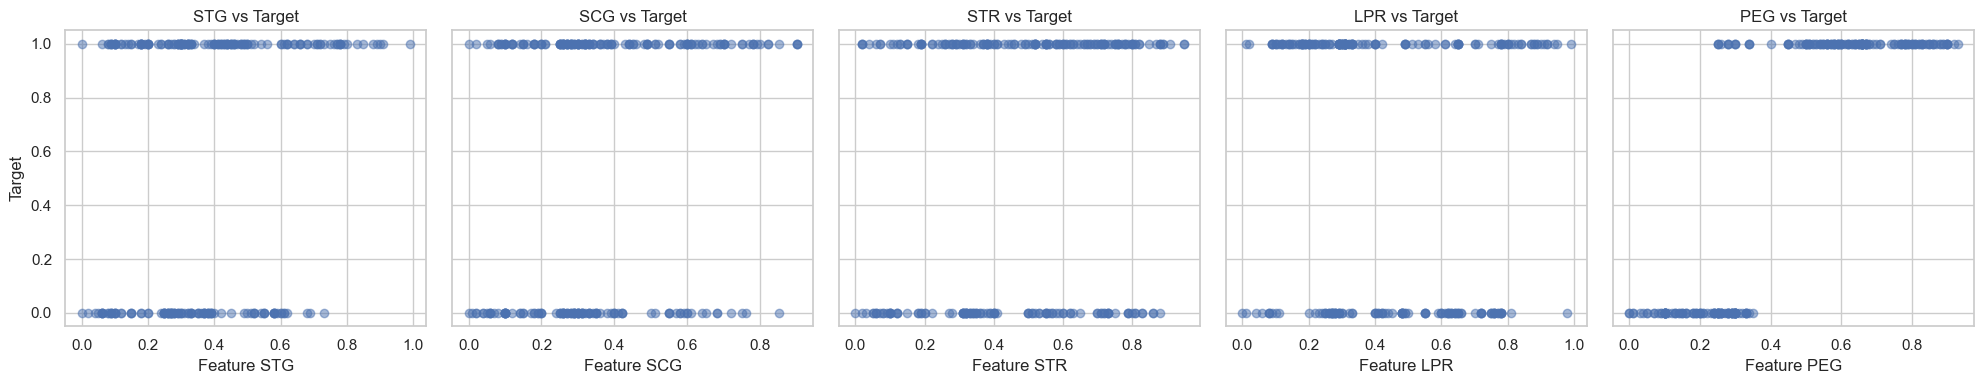

In [10]:
df = pd.read_csv("data/students.csv")

X = df.iloc[:, :5]
y = df.iloc[:, -1]

plt.figure(figsize=(15, 10))

for i, col in enumerate(X.columns):
    thresholds, ginis, _, _ = find_best_split(X[col], y)
    plt.plot(thresholds, ginis, label=f"Feature {col}")

plt.xlabel("Threshold")
plt.ylabel("Gini Criterion")
plt.title("Gini vs Threshold for Each Feature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for i, col in enumerate(X.columns):
    axes[i].scatter(X[col], y, alpha=0.5)
    axes[i].set_xlabel(f"Feature {col}")
    axes[i].set_title(f"{col} vs Target")
    axes[i].grid(True)

axes[0].set_ylabel("Target")
plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**

PEG — лучший признак по критерию Джини. Его кривая сильно выделяется: имеет наименьшее (наиболее отрицательное) значение критерия Джини. Это значит, что деление по признаку PEG приводит к наиболее чистым подвыборкам.

Это полностью согласуется со scatter-графиками. На scatter-графике для PEG классы (0 и 1) чётко разделены по диапазонам значений. Есть чёткий "порог", разделяющий классы, без большого пересечения. А другие признаки имеют больше перекрытия между классами. Деление по ним создаёт поддеревья со смешанными классами, что подтверждается плоскими кривыми Джини.

Кривая для “хорошего” признака имеет V-образную или U-образную форму и чёткий минимум, где Gini резко падает и большую амплитуду между пиком и минимумом.

Кривые “плохих” признаков почти плоские, с малым разбросом значений Джини, не имеют выраженного минимума. Это говорит о том, что деление по таким признакам почти не влияет на чистоту подвыборок.


__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [11]:
columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", "gill-attachment",
    "gill-spacing", "gill-size", "gill-color", "stalk-shape", "stalk-root",
    "stalk-surface-above-ring", "stalk-surface-below-ring", "stalk-color-above-ring",
    "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type",
    "spore-print-color", "population", "habitat"
]

df = pd.read_csv('data/agaricus-lepiota.data', names=columns)

for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X, y = df.drop("class", axis=1).values, df["class"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

tree = DecisionTree(["categorical"] * X.shape[1])
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)

display(f"Accuracy: {acc:.5f}")

'Accuracy: 0.98572'

__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

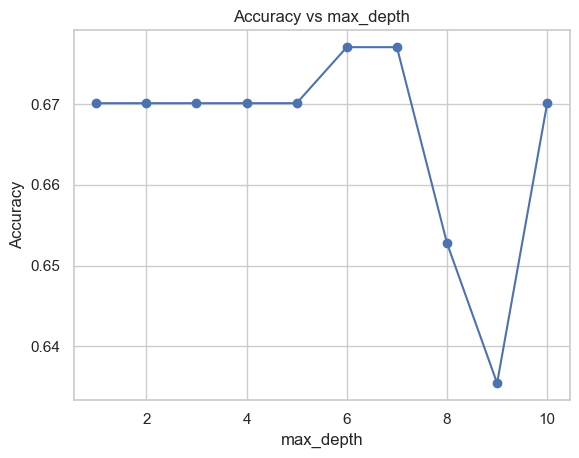

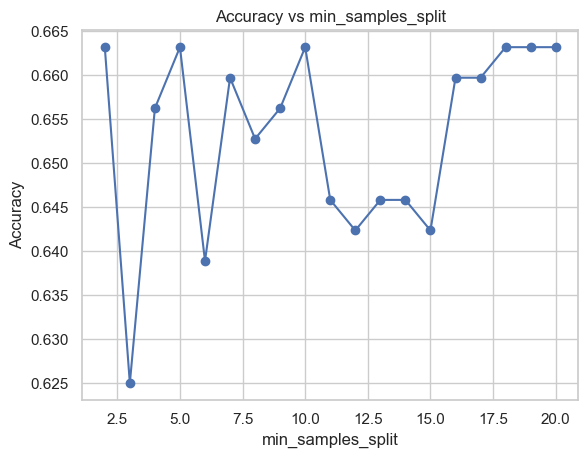

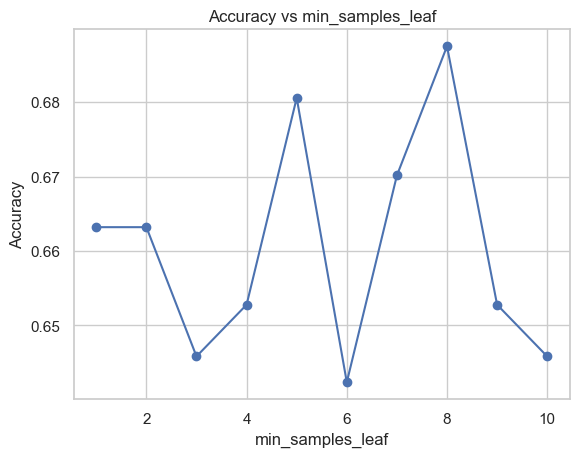

In [12]:
df = pd.read_csv('data/tic-tac-toe-endgame.csv')

X, y = df.drop('V10', axis=1).values, (df['V10'] == 'positive').astype(int).values

feature_types = ['categorical'] * X.shape[1]

def evaluate_param(name, values):
    scores = []

    for val in values:
        kwargs = {name: val}
        clf = DecisionTree(feature_types, **kwargs)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        scores.append(acc)

    plt.figure()
    plt.plot(values, scores, marker='o')
    plt.title(f"Accuracy vs {name}")
    plt.xlabel(name)
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

evaluate_param('max_depth', list(range(1, 11)))
evaluate_param('min_samples_split', list(range(2, 21)))
evaluate_param('min_samples_leaf', list(range(1, 11)))

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [13]:
def load_and_preprocess(name, url):
    df = pd.read_csv(url, header=None)
    
    if name == "mushrooms":
        X = df.iloc[:, 1:]
        y = df.iloc[:, 0]
    elif name == "tic_tac_toe":
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
    elif name == "cars":
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1].replace({'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1})
    elif name == "nursery":
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1].replace({'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1})
    
    le = LabelEncoder()
    X_encoded = X.apply(le.fit_transform)
    y_encoded = le.fit_transform(y) if y.dtype == object else y.values
    return X_encoded, y_encoded

In [14]:
class DecisionTreeReal:
    def fit(self, X, y):
        self.clf = DecisionTree(["real"] * X.shape[1])
        self.clf.fit(X.values.astype(float), y)

    def predict(self, X):
        return self.clf.predict(X.values.astype(float))

class DecisionTreeCategorical:
    def fit(self, X, y):
        self.clf = DecisionTree(["categorical"] * X.shape[1])
        self.clf.fit(X.values, y)

    def predict(self, X):
        return self.clf.predict(X.values)

class DecisionTreeOneHot:
    def fit(self, X, y):
        self.enc = OneHotEncoder(sparse_output=False)
        X_encoded = self.enc.fit_transform(X)
        self.clf = DecisionTree(["real"] * X_encoded.shape[1])
        self.clf.fit(X_encoded, y)

    def predict(self, X):
        X_encoded = self.enc.transform(X)
        return self.clf.predict(X_encoded)

class SklearnWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model_cls):
        self.model_cls = model_cls

    def fit(self, X, y):
        self.model = self.model_cls()
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [15]:
results = {}
scorer = make_scorer(accuracy_score)

urls = {
    "mushrooms": "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data",
    "tic_tac_toe": "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data",
    "cars": "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data",
    "nursery": "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"
}

for name, url in urls.items():
    X, y = load_and_preprocess(name, url)
    
    scores_real = cross_val_score(SklearnWrapper(DecisionTreeReal), X, y, cv=10, scoring=scorer).mean()
    scores_cat = cross_val_score(SklearnWrapper(DecisionTreeCategorical), X, y, cv=10, scoring=scorer).mean()
    scores_oh = cross_val_score(SklearnWrapper(DecisionTreeOneHot), X, y, cv=10, scoring=scorer).mean()
    scores_sklearn = cross_val_score(DecisionTreeClassifier(), X, y, cv=10, scoring=scorer).mean()

    results[name] = [scores_real, scores_cat, scores_oh, scores_sklearn]
    print(f"  - Real features: {scores_real:.4f}")
    print(f"  - Categorical features: {scores_cat:.4f}")
    print(f"  - One-Hot encoding: {scores_oh:.4f}")
    print(f"  - scikit-learn: {scores_sklearn:.4f}")

columns = ["DecisionTree (Real)", "DecisionTree (Categorical)", "DecisionTree (One-Hot)", "DecisionTreeClassifier"]
df_results = pd.DataFrame(results, index=columns).T
print("\nFinal Results:")
print(df_results)

  - Real features: 0.9764
  - Categorical features: 0.9937
  - One-Hot encoding: 0.9667
  - scikit-learn: 0.9567
  - Real features: 0.4022
  - Categorical features: 0.4951
  - One-Hot encoding: 0.3866
  - scikit-learn: 0.7957
  - Real features: 0.9148
  - Categorical features: 0.9542
  - One-Hot encoding: 0.9194
  - scikit-learn: 0.9427
  - Real features: 0.9998
  - Categorical features: 0.9998
  - One-Hot encoding: 0.9998
  - scikit-learn: 0.9997

Final Results:
             DecisionTree (Real)  DecisionTree (Categorical)  \
mushrooms               0.976368                    0.993724   
tic_tac_toe             0.402226                    0.495077   
cars                    0.914777                    0.954208   
nursery                 0.999846                    0.999846   

             DecisionTree (One-Hot)  DecisionTreeClassifier  
mushrooms                  0.966658                0.956689  
tic_tac_toe                0.386634                0.795658  
cars                     

__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Порядок ранжирования алгоритмов различается от датасета к датасету. Это говорит о том, что эффективность разных подходов зависит от природы данных, включая: типы признаков, количество классов, соотношение между признаками и целевой переменной.

В результатах присутствует компонента случайности: нестабильная сортировка категорий и отсутствие зафиксированного random_state при разбиении.

Чтоб повлиять на случайность нужно использовать кросс-валидацию с random_state для получения устойчивых оценок, подбирать гиперпараметры и пробовать ансамбли.

Вставьте что угодно, описывающее ваши впечатления от этого задания: